In [1]:
import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import exoplanet as xo
from celerite2.theano import terms, GaussianProcess
import starry
import pdb
from astropy import constants as const
from astropy import units as u

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


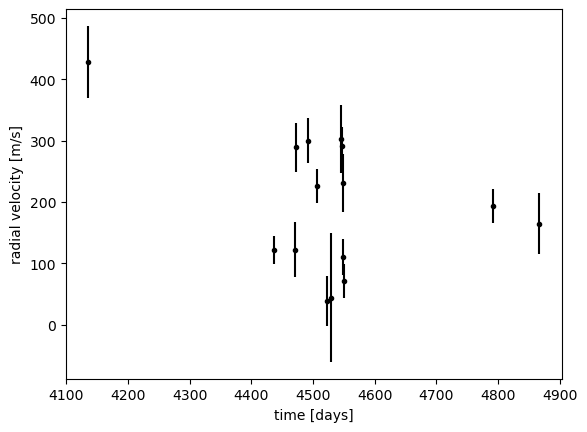

In [82]:
# url = "https://raw.githubusercontent.com/California-Planet-Search/radvel/master/example_data/epic203771098.csv"
# data = pd.read_csv(url, index_col=0)

data = pd.read_table('/Users/tuca/Downloads/hpf.dat', header = 0,
                 names = ['time', 'radial_velocity', 'rv_error', 'HPF'])
#data
time = (data['time'] - 2454833).values
rad_vel = data['radial_velocity'].values
rv_err = data['rv_error'].values

# time = np.array(data.time - 2454833)
# rad_vel = np.array(data.radial_velocity)
# rv_err = np.array(data.rv_error)
# # Compute a reference time that will be used to normalize the trends model
time_ref = 0.5 * (time.min() + time.max())

# # Also make a fine grid that spans the observation window for plotting purposes
t = np.linspace(time.min() - 5, time.max() + 5, 100)

plt.errorbar(time, rad_vel, yerr = rv_err, fmt=".k")
plt.xlabel("time [days]")
_ = plt.ylabel("radial velocity [m/s]")

In [83]:
time_ref

4501.264127866831

In [105]:
periods = [6.7252337648, 1000]
period_errs = [0.1, 500]
t0s = [2457221.8349184883 - 2454833, 2458213.8222186137 - 2454833] #[2388.835, 3380.822]
t0_errs = [0.1, 0.1]
duration = [0.9/24, 15.71/24]
nplanets = 2
R_star = [0.79,0.02] #in solar radii
M_star = [0.82,0.03] #in solar mass
Expected_msini = [1,1] #in earth units #caleb check
Teff = [4870, 88] #in Kelvin and uncertainty is +/- 88
ecc_fit = False

Ks = xo.estimate_semi_amplitude(periods, time, rad_vel, rv_err, t0s=t0s)
print("The semi-amplitudes:",Ks, "m/s")

Rsun2Rearth = (const.R_sun/const.R_earth).value
RsunPerDay = ((const.R_sun/u.d).to(u.m/u.s)).value
Rsun2AU = (const.R_sun).to(u.au).value



with pm.Model() as model:
    
    mean = pm.Normal("mean", mu=0.0, sigma=1.0, testval = 1)
    ustar = xo.distributions.QuadLimbDark("u")
    
#     # Stellar Parameters
#     BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=1.5)
#     m_star = BoundedNormal("m_star", mu=M_star[0], sd=M_star[1])
#     r_star = BoundedNormal("r_star", mu=R_star[0], sd=R_star[1])
#     teff = pm.Bound(pm.Normal, lower=2000, upper=7000)("teff", mu=Teff[0], sd=Teff[1])
#     st_lum = pm.Deterministic("st_lum", (R_star**2) * ((Teff/5777)**4)) #stellar luminosity #derived parameter
#     star_params = [mean, ustar] 
    
    # Planet parameters
    ror = pm.Uniform("ror", lower=0.01, upper = 0.99, shape=nplanets) #, testval=np.array([0.04, 0.06]))
    r_pl = pm.Deterministic("r_pl", ror*R_star) #in physical units aka stellar radii #not a free parameter but you can calculate at every step
    m_pl = pm.Uniform("m_pl", lower=0.1, upper=3e4, testval=Expected_msini, shape=nplanets)
    # deterministic means values that were derived from the model
    density_pl = pm.Deterministic("density_pl", m_pl/((r_pl*Rsun2Rearth)**3) * 5.514) # Convert from rho_earth to g/cm3
    
    # Wide log-normal prior for semi-amplitude

    logK = pm.Normal(
        "logK", mu=np.log(Ks), sd=2.0, shape = nplanets, testval=np.log(Ks)
    )
    # Orbital parameters
    period = pm.Normal("period", mu = np.array(periods), sigma= np.array(period_errs), shape=nplanets)
    t0 = pm.Normal("t0", mu=t0s, sigma=np.array(t0_errs), shape=nplanets)
    b = pm.Uniform("b", lower = 0, upper = 1, shape=nplanets)
    logP = pm.Normal(
        "logP",
        mu=np.log(periods),
        sd=np.array(period_errs) / np.array(periods),
        shape= nplanets,
        testval=np.log(periods),
    )
    P = pm.Deterministic("P", tt.exp(logP))
    
    if ecc_fit:
        # for an eccentric orbit # 
        ecs = pmx.UnitDisk("ecs", testval=np.array([[0.1, 0.1]] * nplanets).T, shape=(2, nplanets))
        ecc = pm.Deterministic("ecc", tt.sum(ecs ** 2, axis=0))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
    else:
        # for circular orbit #
        ecc = np.repeat(0, nplanets)
        omega = np.repeat(np.pi/2, nplanets)

    #Jitter & a quadratic RV trend 
    logs = pm.Normal("logs", mu=np.log(np.median(rv_err)), sd=5.0)
    trend = pm.Normal("trend", mu=0, sd=10.0 ** -np.arange(3)[::-1], shape=3)
    

    # Orbit Model
    orbit = xo.orbits.KeplerianOrbit(r_star = R_star, m_star= M_star, 
                                     period = P, t0 = t0, b = b, 
                                     ecc = ecc, omega = omega, 
                                     m_planet = xo.units.with_unit(m_pl, u.M_earth))
    pm.Deterministic("rho_circ", orbit.rho_star)
    pm.Deterministic("aor", orbit.a / r_star)
#     orbit = xo.orbits.KeplerianOrbit(period = P, t0=t0, ecc=ecc, omega=omega)
    
    
    # A function for computing the full RV model
    def get_rv_model(t, name=""):
        # First the RVs induced by the planets
        vrad = orbit.get_radial_velocity(t, K = tt.exp(logK)) 
        pm.Deterministic("vrad" + name, vrad)

        # Define the background model
        A = np.vander(t - time_ref, 3)
        bkg = pm.Deterministic("bkg" + name, tt.dot(A, trend))

        # Sum over planets and add the background to get the full model
        return pm.Deterministic("rv_model" + name, tt.sum(vrad, axis=-1) + bkg)
    
    # Define the RVs at the observed times
    rv_model = get_rv_model(time)

    # Also define the model on a fine grid as computed above (for plotting)
    rv_model_pred = get_rv_model(t, name="_pred")

    # Finally add in the observation model. This next line adds a new contribution
    # to the log probability of the PyMC3 model

    err = tt.sqrt(rv_err**2 + tt.exp(2 * logs))
    pm.Normal("obs", mu = rv_model, sd = err, observed = rad_vel)



The semi-amplitudes: [107.83603815  54.74316875] m/s


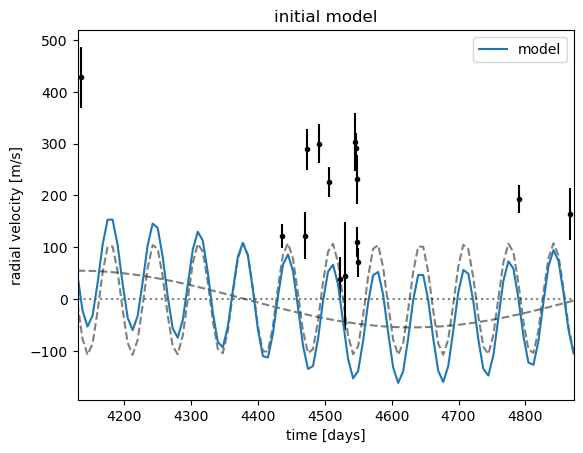

In [106]:
plt.errorbar(time, rad_vel, yerr = rv_err, fmt=".k")

with model:
    plt.plot(t, pmx.eval_in_model(model.vrad_pred), "--k", alpha=0.5)
    plt.plot(t, pmx.eval_in_model(model.bkg_pred), ":k", alpha=0.5)
    plt.plot(t, pmx.eval_in_model(model.rv_model_pred), label="model")


plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("initial model")

In this plot, the background is the dotted line, the individual planets are the dashed lines, and the full model is the blue line.

It doesn't look amazing so let's fit for the maximum a posterior parameters.